# S&SM
## L1. Alina Kragel, gr. 9

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import enum
from matplotlib import cycler
from functools import reduce

from math import gcd
from scipy.stats import norm, chi2

In [2]:
colors = cycler('color', ['#117A65'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [3]:
def set_styles(df):
    s = df.style.format(precision=10)
    return s

Шпаргалка для LCG

In [4]:
def getA(m):
    def deliteli(val):
        return [*filter(lambda x: val % x == 0, range(1, val // 2 + 1)), val]

    def isSimple(val):
        return val == 1 or len(deliteli(val))==2

    sd = list(filter(lambda x: isSimple(x), deliteli(m)))
    b = reduce(lambda a, x: a * x, sd)
    if (m % 4 == 0 and b % 4 != 0):
        b *= 4
    return b + 1

##### 1. Реализация линейного конгруэнтного генератора

In [6]:
class LCG:

    def __init__(self, x0, a, c, M):        
        self.a = a
        self.c = c
        self.M = M
        self.x = x0
    
    def __call__(self):
        self.x = (self.a * self.x + self.c) % self.M
        return self.x / self.M

##### 2. Реализация генератора Маклорена-Марсальи

In [7]:
class MMG:
    def __init__(self, g1, g2, k):
        assert k > 0
        self.k = k
        self.g1 = g1
        self.g2 = g2
        self.v = [g1() for _ in range(k)]
    
    def __call__(self):
        s = int(self.g2() * self.k)
        rx = self.v[s]
        self.v[s] = self.g1()
        return rx

In [8]:
class MMT_Options(enum.Enum):
    mean_option = 0
    var_option = 1
    mean_and_var_option = 2

##### - Диаграмма рассеяния

In [9]:
def draw_scatter(rng, n):
    vals = [rng() for _ in range(n)]
    plt.scatter(vals[:-1], vals[1:], s=1)
    
def draw_scatter_for_gens(n, gens):
    plt.figure(figsize=(20, 10), dpi=150)
    plt.suptitle(f"n = {n}")
    plt.figure(figsize=(16, 12))
    for i, (gn, gg) in enumerate(gens):
        plt.subplot(2, 2, i + 1)
        plt.title(gn)
        draw_scatter(gg(), n)

##### - Тест совпадения моментов:

In [10]:
def test_matching_moments(rng, n, eps, result_spec: MMT_Options):
    s1 = 0
    s2 = 0
    
    for _ in range(n):
        ai = rng()
        s1 += ai
        s2 += ai ** 2
        
    m = s1 / n
    s = (n * s2 - s1 ** 2) / (n * (n - 1))
    
    xi1 = abs(m - 1 / 2)
    xi2 = abs(s - 1 / 12)
    
    c1 = math.sqrt((12 * n))
    c2 = (n - 1) / math.sqrt(0.0056 * n + 0.0028 - 0.0083 / n)
    
    delta = norm.ppf(1 - eps / 2)
    
    result = {}
    if result_spec is MMT_Options.mean_option:
        result.update({"statistic": round(xi1 * c1, 10), 
                       "H0": xi1 * c1 < delta, 
                       "delta": round(delta, 10), 
                       "eps": eps})
    if result_spec is MMT_Options.var_option:
        result.update({"statistic": round(xi2 * c2, 10), 
                       "H0": xi2 * c2 < delta, 
                       "delta": round(delta, 10), 
                       "eps": eps})
    if result_spec is MMT_Options.mean_and_var_option:
        result.update({"statistic": round(xi1 * c1, 10), 
                       "H0": xi1 * c1 < delta, 
                       "delta": round(delta, 10), 
                       "eps": eps})
        result.update({"statistic": round(xi2 * c2, 10), 
                       "H0": xi2 * c2 < delta, 
                       "delta": round(delta, 10), 
                       "eps": eps})
    return result

##### - Тест 'ковариация':

In [11]:
def test_covariation(rng, n, j, eps):
    pai = rng()
    
    data_saver = []
    for _ in range(n + j):
        data_saver.append(rng())
    
    rh = sum([data_saver[i] * data_saver[i + j] for i in range(n-j)]) / (n - j - 1) - (n * np.mean(data_saver) ** 2) / (n - 1)
    if j == 0:
        stat = np.fabs(rh - 1 / 12)
    else:
        stat = np.fabs(rh)
    delta = norm.ppf(1 - eps / 2) / (12 * np.sqrt(n - 1))
    
    return {"statistic": round(stat, 10), 
            "H0": stat < delta, 
            "delta": round(delta, 10), 
            "eps": eps}

##### - Критерий хи-квадрат Пирсона:

In [12]:
def test_chi2(rng, n, k, eps):
    nu = [0] * k
    for _ in range(n):
        nu[int(rng() * k)] += 1
        
    chi2s = 0
    for vi in nu:
        chi2s += (vi - n / k) ** 2 / (n / k)
    delta = chi2(k - 1).ppf(1 - eps)
    
    return {"statistic": chi2s, 
            "H0": chi2s < delta, 
            "delta": round(delta, 10), 
            "eps": eps}

##### Функция для генерации выборок заданными генераторами
LCG1: x0 = 19, a = 174, c = 1, M = 173\
LCG2: x0 = 2 ** 8, a = 75, c = 74, M = 2 ** 16 + 1\
LCG3: x0 = 2 ** 12, a = 1 140 671 485, c = 12 820 163, M = 2 ** 24\
MMG: LCG3, LCG2, k = 100

In [13]:
def get_gens(ext=False):
    
    gens = []
    if not ext:
        gens.append(("LCG1", lambda: LCG(19, 17, 1, 167)))
        gens.append(("LCG2", lambda: LCG(2 ** 8, 75, 74, 2 ** 16 + 1)))
        gens.append(("LCG3", lambda: LCG(2 ** 12, 1_140_671_485, 12_820_163, 2 ** 24)))
        gens.append(("MMG", lambda: MMG(gens[2][1](), gens[1][1](), 100)))
    else:
        gens.append(LCG(19, 17, 1, 167))
        gens.append(LCG(2 ** 8, 75, 74, 2 ** 16 + 1))
        gens.append(LCG(2 ** 12, 1140671485, 12820163, 2 ** 24))
        gens.append(MMG(gens[2], gens[1], 100))
    return gens

##### Функция для оптимального проведения тестов

In [14]:
def get_data(test, MMT_Spec: MMT_Options, eps=0.04):            
    n1 = 10 ** 4
    n2 = 10 ** 6
    gens = get_gens()
    bunch = []
    additional_data = []
    gen_bunch1 = []
    gen_bunch2 = []
    
    
    if test == 'MMT':
        for title, gen in gens:
            mm_res_1 = test_matching_moments(gen(), n1, eps, MMT_Spec)
            mm_res_2 = test_matching_moments(gen(), n2, eps, MMT_Spec)
            gen_bunch1.extend([n1, mm_res_1['statistic'], str(mm_res_1['H0']), mm_res_1['delta']])
            gen_bunch2.extend([n2, mm_res_2['statistic'], str(mm_res_2['H0']), mm_res_2['delta']])
        bunch.append(gen_bunch1)
        bunch.append(gen_bunch2)
        
    
    if test == 'CT':
        cells = 11
        bunch = [[] for _ in range(cells * 2)]
        for title, gen in gens:
            gen_bunch = []
            for size in [n1, n2]:
                for cell in range(cells):
                    cov_res = test_covariation(gen(), size, cell, eps)
                    gen_bunch.append([size, cov_res['statistic'], str(cov_res['H0']), cov_res['delta']])
                    
            for gen_el, bunch_el in zip(gen_bunch, bunch):
                bunch_el.extend(gen_el)

            
    if test == 'CHI':
        for title, gen in gens:
            chi1_res = test_chi2(gen(), n1, 1000, eps)
            chi2_res = test_chi2(gen(), n2, 1000, eps)
            gen_bunch1.extend([n1, chi1_res['statistic'], str(chi1_res['H0']), chi1_res['delta']])
            gen_bunch2.extend([n2, chi2_res['statistic'], str(chi2_res['H0']), chi2_res['delta']])
        bunch.append(gen_bunch1)
        bunch.append(gen_bunch2)
        
    return bunch, additional_data

##### Отчетная функция

In [15]:
def get_report_for_test(test, MMT_Spec=MMT_Options.mean_option):
    data, temp_data  = get_data(test, MMT_Spec)
    if temp_data:
        temp_df = pd.DataFrame(temp_data,
                  index=pd.Index(['LCG1', 'LCG2', 'LCG3', 'MMG']),
                  columns=['Mean', 'Variance'])

    df = pd.DataFrame(data,
                      columns=pd.MultiIndex.from_product([['LCG1', 'LCG2', 'LCG3', 'MMG'],
                                                          ['n', 'statisctics', 'H0', 'delta']], 
                                                         names=['Gens:', ' ']))
    if temp_data:
        return set_styles(df), set_styles(temp_df)
    return set_styles(df)

### Проведение эксперимента

In [16]:
n = 10 ** 6

In [17]:
gens = get_gens(ext=True)
data = []
table_data = []

for gen in gens:
    vals = [gen() for _ in range(n)]
    data.append(vals)
    
for el in data:
    table_data.append([np.mean(el), np.var(el, ddof=1)])

Рассчитанные математические ожидания и дисперсии для сгенерированных выборок

In [18]:
temp_df = set_styles(pd.DataFrame(table_data,
                  index=pd.Index(['LCG1', 'LCG2', 'LCG3', 'MMG']),
                  columns=['Mean', 'Variance']))
temp_df

,Mean,Variance
LCG1,0.4973666407,0.0838110332
LCG2,0.4999836703,0.0833237118
LCG3,0.5002383668,0.0833629888
MMG,0.5001544935,0.0833774277


#### Диаграммы рассеяния

<Figure size 3000x1500 with 0 Axes>

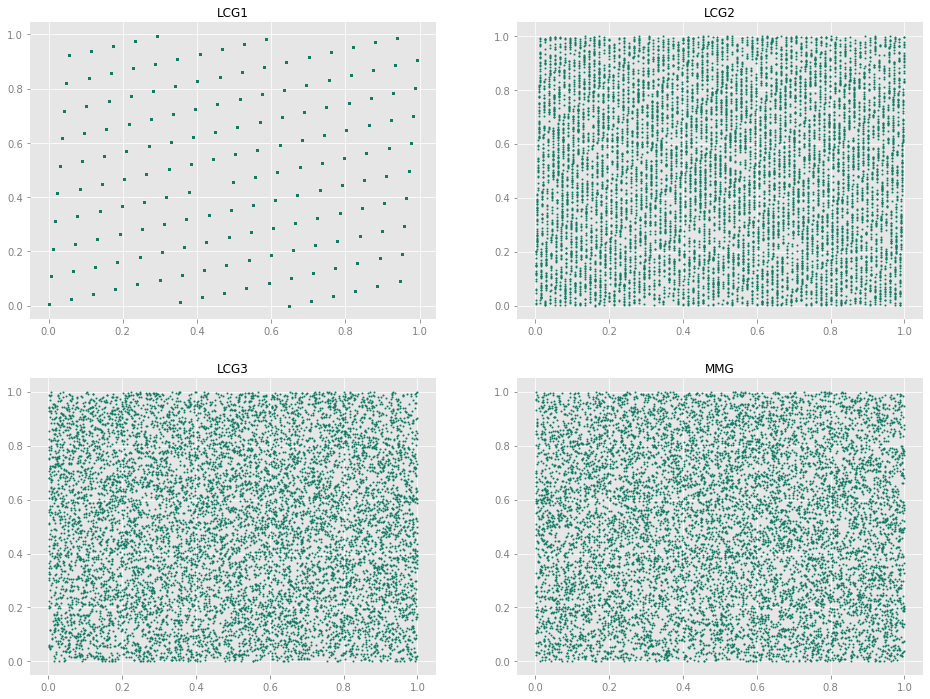

In [19]:
draw_scatter_for_gens(10_000, get_gens())

<Figure size 3000x1500 with 0 Axes>

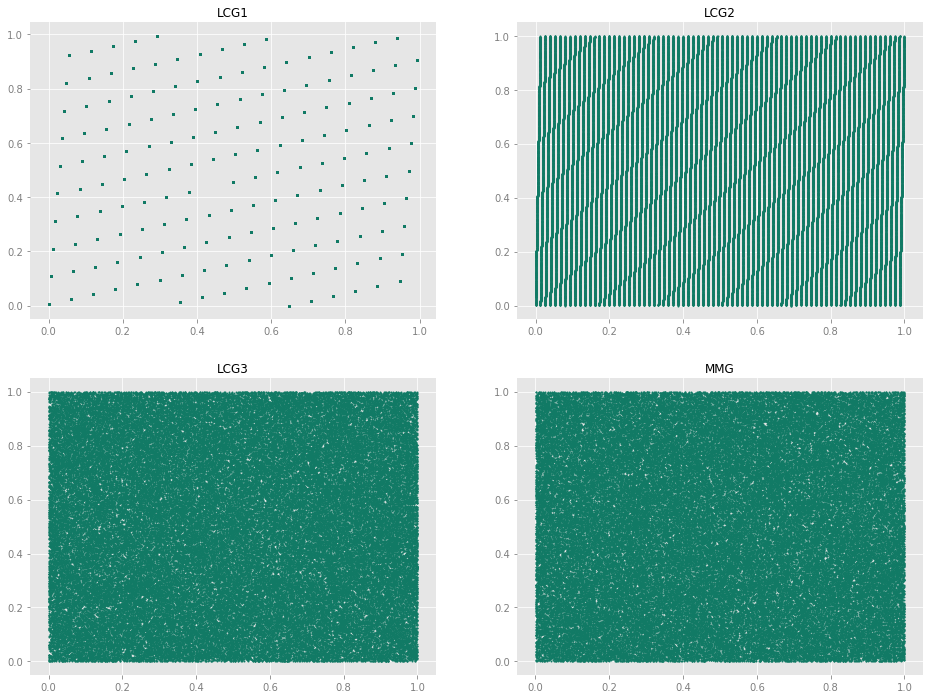

In [27]:
draw_scatter_for_gens(100_000, get_gens())

#### Результаты проведения тестов совпадения моментов для математического ожидания

In [21]:
get_report_for_test('MMT', MMT_Options.mean_option)

#### Результаты проведения тестов совпадения моментов для дисперсии

In [22]:
get_report_for_test('MMT', MMT_Options.var_option)

#### Результаты проведения теста ковариаций

In [23]:
get_report_for_test('CT')

#### Результаты проведения критерия хи-квадрат

In [24]:
get_report_for_test('CHI')